In [1]:
# Install packages
!pip install rouge-score

In [2]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter
import os
import sys
import nltk.translate.bleu_score as ntbs  # BLEU scoring basics
import rouge_score.rouge_scorer as rouge_scorer  # ROUGE scoring basics
sys.path.insert(0, '../input/aida-metrics-functions')  # custom metrics implementation
import metrics as met  # custom metrics BLUE-1 pecsision and ROUGE-L recall

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import time
import datetime as dt
import json

# Load data

In [3]:
#Import the dataset and read the image into a seperate variable
CAPTIONS_PATH = '../input/flickr8k/captions.txt'
DIR_IMAGES = "../input/flickr8k/Images"
DIR_IMAGE_FEATURES = '../input/image-features-inceptv3/image_features'

In [4]:
df_cap = pd.read_csv(CAPTIONS_PATH)
df_cap.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
unique_images = df_cap['image'].unique()
_, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)

df_cap['test'] = df_cap['image'].isin(test_images)

sum((df_cap['test']==False)*1), sum((df_cap['test']==True)*1)

(32360, 8095)

In [6]:
# get min and max length of captions
def create_tokenizer(captions, num_words=None):
    texts = [f'<start> {s} <end>' for s in captions]
    
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    if num_words is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=special_chars)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=num_words, oov_token='<unk>',
            filters=special_chars)
        
    tokenizer.fit_on_texts(texts)    
    # Adding PAD to tokenizer list
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'   
   
    return tokenizer

In [7]:
tokenizer = create_tokenizer(df_cap['caption'].values)

In [8]:
# get all sequences
tok_seqs_train = tokenizer.texts_to_sequences(df_cap[df_cap['test']==False]['caption'].map(lambda x: f'<start> {x} <end>').values)
tok_seqs_test = tokenizer.texts_to_sequences(df_cap[df_cap['test']==True]['caption'].map(lambda x: f'<start> {x} <end>').values)

image_names_train = df_cap[df_cap['test']==False]['image'].values
image_names_test = df_cap[df_cap['test']==True]['image'].values

In [9]:
tok_seqs_train = pad_sequences(tok_seqs_train, padding='post')

MAX_SEQ_LEN = tok_seqs_train.shape[-1]
print(f'Maximal sequence length is: {MAX_SEQ_LEN}')

tok_seqs_test = pad_sequences(tok_seqs_test, maxlen=MAX_SEQ_LEN, padding='post')

print(f'tok_seqs_train.shape={tok_seqs_train.shape}')
print(f'tok_seqs_test.shape.shape={tok_seqs_test.shape}')

Maximal sequence length is: 39
tok_seqs_train.shape=(32360, 39)
tok_seqs_test.shape.shape=(8095, 39)


# Create datasets

In [10]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
VOCAB_SIZE = len(tokenizer.word_index)

In [11]:
# Load the numpy files
def map_func(img_name, caption):    
    img_tensor = np.load(os.path.join(DIR_IMAGE_FEATURES, img_name.decode('utf-8') + '.npy') )
    return img_tensor, caption

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((image_names_train, tok_seqs_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

#--------------------------------------
test_dataset = tf.data.Dataset.from_tensor_slices((image_names_test, tok_seqs_test))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Batch only no shuffle
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# test datasets
b_imgs_train, b_caps_train = next(iter(train_dataset))
b_imgs_test, b_caps_test = next(iter(test_dataset))

print(f'batch shape (train_imgs, train_caps) = ({b_imgs_train.shape}, {b_caps_train.shape})')
print(f'batch shape   (test_imgs, test_caps) = ({b_imgs_test.shape}, {b_caps_test.shape})')

batch shape (train_imgs, train_caps) = ((64, 64, 2048), (64, 39))
batch shape   (test_imgs, test_caps) = ((64, 64, 2048), (64, 39))


# Positional encoding

because we DO NOT use here RNN's or convolutions we need to handle somehow relative positions

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [15]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [16]:
## just check and visualize positional encoding
#n, d = 2048, 512
#pos_encoding = positional_encoding(n, d)
#print(pos_encoding.shape)
#pos_encoding = pos_encoding[0]
#
## Juggle the dimensions for the plot
#pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
#pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
#pos_encoding = tf.reshape(pos_encoding, (d, n))
#
#plt.pcolormesh(pos_encoding, cmap='RdBu')
#plt.ylabel('Depth')
#plt.xlabel('Position')
#plt.colorbar()
#plt.show()

# Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [17]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [18]:
# try out padding mask
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [19]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [20]:
# try out look_ahead mask
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Create Attention and some helpers

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    #
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

Create a MultiHeadAttention layer to try out. At each location in the sequence, y, the MultiHeadAttention runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [23]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point wise feed forward network

In [24]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [25]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, drop_out=0.1):
        super(Encoder, self).__init__()

        self.dense1 = tf.keras.layers.Dense(embedding_dim * 2, activation='relu')
        self.drop_out = tf.keras.layers.Dropout(drop_out)
        self.dense2 = tf.keras.layers.Dense(embedding_dim, activation='tanh')
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    
    def call(self, x_in, training):
        x = self.dense1(x_in)
        x = self.drop_out(x)
        x = self.dense2(x)
        out = self.layernorm(x)

        return out

In [27]:
sample_encoder = Encoder(512)

sample_encoder_output = sample_encoder(
    tf.random.uniform((64, 64, 2048)), False)

sample_encoder_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 64, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        )  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [29]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    #tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    tf.random.uniform((64, 50, 512)), sample_encoder_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Decoder

The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [31]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 64]))

# Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [32]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        # was named tokenizer before
        self.encoder = Encoder(d_model)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [33]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    target_vocab_size=VOCAB_SIZE, pe_target=6000)

temp_input = tf.random.uniform((64, 64, 2048)) # encoded picture from resnet
# temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, MAX_SEQ_LEN), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               look_ahead_mask=None, dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 39, 8496])

## Set hyperparameters

In [34]:
# try first with this (get from tf tutorial https://www.tensorflow.org/tutorials/text/transformer#text_tokenization_detokenization)
#num_layers = 4
#d_model = 128 # => 256
#dff = 512
#num_heads = 8
#dropout_rate = 0.1

num_layers = 6
d_model = 256 # => 256
dff = 512
num_heads = 8
dropout_rate = 0.1

In [35]:
# d_model % num_heads

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

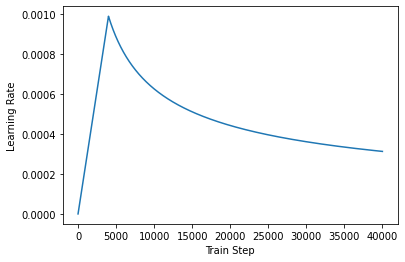

In [38]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):    
    accuracies = tf.equal(real, tf.cast( tf.argmax(pred, axis=2), dtype=tf.int32) )
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [41]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=VOCAB_SIZE,
    pe_target=1000,
    rate=dropout_rate)

In [42]:
#def create_masks(inp, tar):
def create_masks(inp, tar):
    # Encoder padding mask
    # enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    #dec_padding_mask = create_padding_mask(inp)
    # musk must be always 0 [shape=(BSx1x1xSEQ_LEN=64)
    dec_padding_mask = tf.zeros((inp.shape[0], 1, 1, inp.shape[1]), dtype=tf.float32)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    #return enc_padding_mask, combined_mask, dec_padding_mask
    return combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [43]:
checkpoint_path = "./checkpoints/train"
# checkpoint_path = "../input/img-capt-transformer/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "<start> A lion in the jungle is sleeping <end>"

`tar_inp` =  "<start> A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping <end>"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [44]:
EPOCHS = 40

In [45]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # without the last token=<end>
    tar_real = tar[:, 1:] # shifted left so first token is NOT <start> but a real token
    
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     training=True,                                     
                                     look_ahead_mask = combined_mask,
                                     dec_padding_mask = dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [46]:
#b_imgs_test[0]
#b_caps_test[0]
#b_imgs_test.shape, b_caps_test.shape

In [47]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
    
ckpt_save_path = ckpt_manager.save()
print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

Epoch 1 Batch 0 Loss 9.0720 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9129 Accuracy 0.0353
Epoch 1 Batch 100 Loss 8.6709 Accuracy 0.0814
Epoch 1 Batch 150 Loss 8.4255 Accuracy 0.0986
Epoch 1 Batch 200 Loss 8.1584 Accuracy 0.1075
Epoch 1 Batch 250 Loss 7.8694 Accuracy 0.1116
Epoch 1 Batch 300 Loss 7.5705 Accuracy 0.1199
Epoch 1 Batch 350 Loss 7.2881 Accuracy 0.1289
Epoch 1 Batch 400 Loss 7.0395 Accuracy 0.1377
Epoch 1 Batch 450 Loss 6.8198 Accuracy 0.1481
Epoch 1 Batch 500 Loss 6.6207 Accuracy 0.1578
Epoch 1 Loss 6.6014 Accuracy 0.1588
Time taken for 1 epoch: 190.03 secs

Epoch 2 Batch 0 Loss 4.5744 Accuracy 0.2457
Epoch 2 Batch 50 Loss 4.5882 Accuracy 0.2582
Epoch 2 Batch 100 Loss 4.4883 Accuracy 0.2637
Epoch 2 Batch 150 Loss 4.4036 Accuracy 0.2716
Epoch 2 Batch 200 Loss 4.3432 Accuracy 0.2764
Epoch 2 Batch 250 Loss 4.3150 Accuracy 0.2788
Epoch 2 Batch 300 Loss 4.2821 Accuracy 0.2817
Epoch 2 Batch 350 Loss 4.2377 Accuracy 0.2856
Epoch 2 Batch 400 Loss 4.1982 Accuracy 0.2893
Epoch 2 Batch

# Evaluate

The following steps are used for evaluation:

* Encode the input picture (after IceptV3).
* The decoder input is initialized to the `<start>` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* The model makes predictions of the next word for each word in the output. Most of these are redundant. Use the predictions from the last word.
* Concatenate the predicted word to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [48]:
def evaluate_model(image_fn, max_length=MAX_SEQ_LEN, dir_img_feats=None):
    # inp is already converted via InceptV3
    if dir_img_feats is None:
        image_data = np.load(os.path.join(DIR_IMAGE_FEATURES, image_fn + '.npy'))
    else:
        image_data = np.load(os.path.join(dir_img_feats, image_fn + '.npy'))
    encoder_input = tf.convert_to_tensor([image_data])
  
    # the first word to the transformer should be the <start> token.
    start, end = tokenizer.word_index['<start>'], tokenizer.word_index['<end>']
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):        
        combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     training=False,                                                 
                                                     look_ahead_mask=combined_mask,
                                                     dec_padding_mask=dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), dtype=tf.int32)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break

    # output.shape (1, tokens)    
    text = tokenizer.sequences_to_texts(output.numpy())

    return text[0] #, tokens, attention_weights

# Make some predictions

In [49]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptv3 = InceptionV3(include_top=False, weights='imagenet')

def preproc_image(img_name, dir_images, dir_img_feats):
    os.makedirs(dir_img_feats, exist_ok=True)
    
    img_path = os.path.join(dir_images, img_name)
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,(299,299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
        
    img_feats = inceptv3(tf.convert_to_tensor([image]))
    img_feats = tf.reshape(img_feats, (img_feats.shape[0], -1, img_feats.shape[3]))
    np.save(        
        os.path.join(dir_img_feats, img_name + '.npy'),
        img_feats[0].numpy()
    )    
    
#preproc_input('2662262499_3cdf49cedd.jpg')

87916544/87910968 [==============================] - 1s 0us/step


In [50]:
def eval_image_from_test(img_name, dir_images=None, dir_img_feats=None):
    if dir_images is not None:
        preproc_image(img_name, dir_images, dir_img_feats)
    
    if dir_images is None:
        img = plt.imread(os.path.join(DIR_IMAGES, img_name))
    else:
        img = plt.imread(os.path.join(dir_images, img_name))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()
    
    print(f'\nReference captions:\n{"-"*80}')
    for l in df_cap[df_cap['image']==img_name]['caption'].values:
        print(f'- {l}')
    
    prediction = evaluate_model(img_name, dir_img_feats=dir_img_feats)
    print(f'\nPrediction:\n{"-"*80}')
    print(f'- {prediction}')

In [51]:
# df_cap.iloc[0]
image_name = df_cap.iloc[0]['image']
real_text = tokenizer.sequences_to_texts( tokenizer.texts_to_sequences([ df_cap.iloc[0]['caption']]) )
pred_text = evaluate_model(image_name)

print(f'Real caption: {real_text}')
print(f'Pred caption: {pred_text}')

Real caption: ['a child in a pink dress is climbing up a set of stairs in an entry way']
Pred caption: <start> a little girl climbing up a set of stairs in an entry way over a wooden playhouse <end>


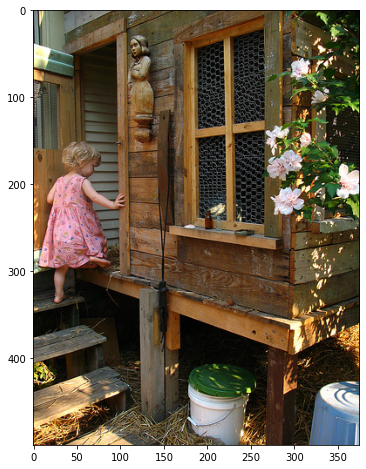


Reference captions:
--------------------------------------------------------------------------------
- A child in a pink dress is climbing up a set of stairs in an entry way .
- A girl going into a wooden building .
- A little girl climbing into a wooden playhouse .
- A little girl climbing the stairs to her playhouse .
- A little girl in a pink dress going into a wooden cabin .

Prediction:
--------------------------------------------------------------------------------
- <start> a little girl climbing up a set of stairs in an entry way over a wooden playhouse <end>


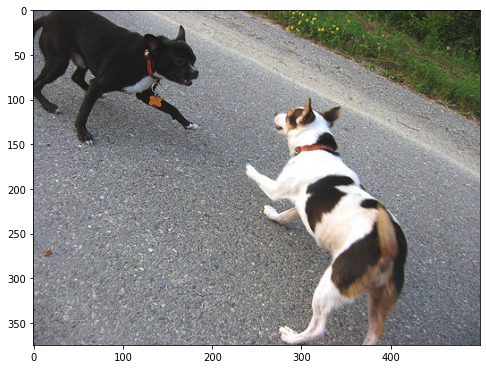


Reference captions:
--------------------------------------------------------------------------------
- A black dog and a spotted dog are fighting
- A black dog and a tri-colored dog playing with each other on the road .
- A black dog and a white dog with brown spots are staring at each other in the street .
- Two dogs of different breeds looking at each other on the road .
- Two dogs on pavement moving toward each other .

Prediction:
--------------------------------------------------------------------------------
- <start> a black dog and a white dog are staring at each other in the street <end>


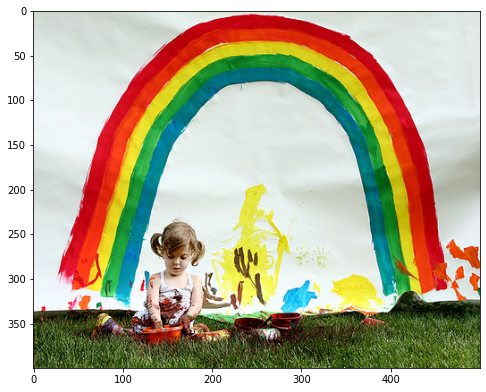


Reference captions:
--------------------------------------------------------------------------------
- A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
- A little girl is sitting in front of a large painted rainbow .
- A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
- There is a girl with pigtails sitting in front of a rainbow painting .
- Young girl with pigtails painting outside in the grass .

Prediction:
--------------------------------------------------------------------------------
- <start> a little girl is sitting in front of a painted rainbow with her hands in the air with her hand in front of a bowl <end>


In [52]:
# show some results
for img_name in df_cap['image'].unique()[:3]:
    eval_image_from_test(img_name)

# Reality check

In [53]:
# preprocess pictures with inceptv3
DIR_REALITY_IMGS = '../input/img-capt-real-check/reality_check'
DIR_REALITY_INCEPT_FEATS = './tmp_image_feats'

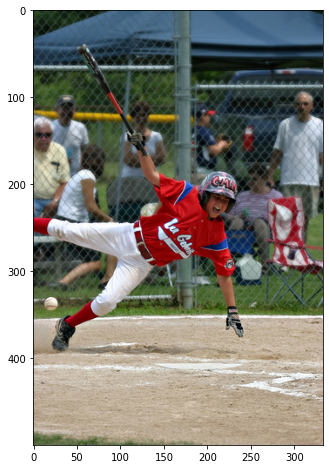


Reference captions:
--------------------------------------------------------------------------------
- A baseball hitter holding a bat falling down .
- A baseball player runs on the field .
- A boy at bat playing a baseball game falls to the ground while onlookers watch .
- A child in a uniform is falling to the ground with a bat in his or her hand .
- This baseball player , dressed in red and white uniform and holding a bat , is falling after being hit by a pitch .

Prediction:
--------------------------------------------------------------------------------
- <start> a young boy wearing a red and yellow uniform kicking a ball with a glove on his face <end>


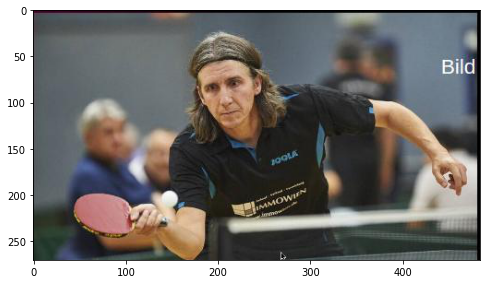


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a woman in a red shirt and black face vest is drinking a ball <end>


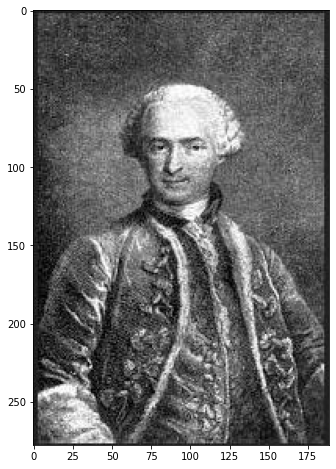


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a man wearing a black hooded coat has some cardboard boots in the air <end>


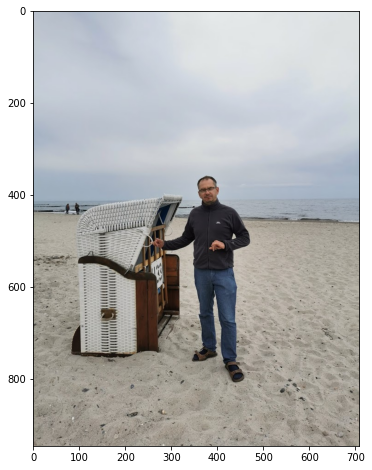


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a man is standing on the beach with a bottle of water in his hand <end>


In [54]:
for f in os.listdir(DIR_REALITY_IMGS):
    eval_image_from_test(f, dir_images=DIR_REALITY_IMGS, dir_img_feats=DIR_REALITY_INCEPT_FEATS)

# Compute scores

In [55]:
actual = []
pred = []
c_true_test = dict()
c_pred_test = dict()
cnt = 0
for img_name in tqdm(df_cap[df_cap['test']==True]['image'].unique()):
    cnt += 1
    image_real_tokens = tokenizer.texts_to_sequences(df_cap[df_cap['image']==img_name]['caption'].map(lambda x: f'<start> {x} <end>').values)
    image_real_captions = tokenizer.sequences_to_texts(image_real_tokens)
    pred_text = evaluate_model(img_name)
    
    actual.append(image_real_captions)
    pred.append( pred_text )
    
    c_true_test[img_name] = image_real_captions
    c_pred_test[img_name] = pred_text
    
actual[:2], len(actual), pred[:2], len(pred)
# tokenizer.texts_to_sequences(df_cap[df_cap['test']==True]['caption'].map(lambda x: f'<start> {x} <end>').values)

100%|██████████| 1619/1619 [47:09<00:00,  1.75s/it]


([['<start> a couple and an infant being held by the male sitting next to a pond with a near by stroller <end>',
   '<start> a couple sit on the grass with a baby and stroller <end>',
   '<start> a couple with their newborn baby sitting under a tree facing a lake <end>',
   '<start> a man and woman care for an infant along the side of a body of water <end>',
   '<start> couple with a baby sit outdoors next to their stroller <end>'],
  ['<start> a man drilling a hole in the ice <end>',
   '<start> a man is drilling through the frozen ice of a pond <end>',
   '<start> a person in the snow drilling a hole in the ice <end>',
   '<start> a person standing on a frozen lake <end>',
   '<start> two men are ice fishing <end>']],
 1619,
 ['<start> a woman in a blue outfit is standing by a tree while the way through a carnival <end>',
  '<start> a man is riding a cross a brown snow vehicle with a group of people behind him <end>'],
 1619)

In [56]:
from nltk.translate.bleu_score import corpus_bleu
print('BLEU-1: %f' % corpus_bleu(actual, pred, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, pred, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, pred, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, pred, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.911508
BLEU-2: 0.824472
BLEU-3: 0.753652
BLEU-4: 0.652682


In [57]:
# Prepare true captures (references) and predicted captures (candidates)
timestamp_str = timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
DIR_RESULT_STORE = './results/'
if not os.path.exists(DIR_RESULT_STORE):
    os.makedirs(DIR_RESULT_STORE, exist_ok=True)
# Serialize data into file
json.dump(c_true_test, open(DIR_RESULT_STORE + f"c_true_test_{timestamp_str}.json", 'w'))
json.dump(c_pred_test, open(DIR_RESULT_STORE + f"c_pred_test_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_test, bleu_1_test = met.evaluate(c_true_test, c_pred_test)
print(f"Metrics for Testset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")

Metrics for Testset:
ROUGE-L recall:    54.81%
BLEU-1 precision:  58.97%


In [58]:
df_out_test = pd.DataFrame({'real': np.concatenate(actual), 'pred': np.concatenate([[s]*5 for s in pred])})
df_out_test.head()

,real,pred
0,<start> a couple and an infant being held by t...,<start> a woman in a blue outfit is standing b...
1,<start> a couple sit on the grass with a baby ...,<start> a woman in a blue outfit is standing b...
2,<start> a couple with their newborn baby sitti...,<start> a woman in a blue outfit is standing b...
3,<start> a man and woman care for an infant alo...,<start> a woman in a blue outfit is standing b...
4,<start> couple with a baby sit outdoors next t...,<start> a woman in a blue outfit is standing b...


In [59]:
df_out_test.to_csv('test_results.csv', index=False)

# Reality check with model from Version 7

In [60]:
checkpoint_path_1 = "../input/img-capt-transformer/checkpoints/train"

ckpt_1 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager_1 = tf.train.CheckpointManager(ckpt_1, checkpoint_path_1, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager_1.latest_checkpoint:
    ckpt_1.restore(ckpt_manager_1.latest_checkpoint)
    print('Latest checkpoint restored from version 7!!')

Latest checkpoint restored from version 7!!


Reality check with model from Version 7




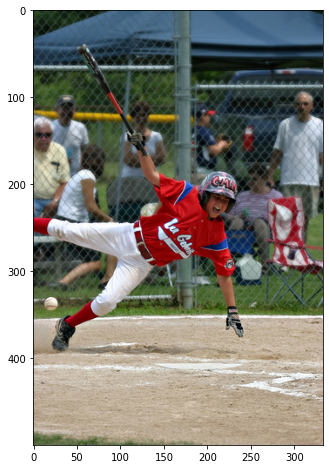


Reference captions:
--------------------------------------------------------------------------------
- A baseball hitter holding a bat falling down .
- A baseball player runs on the field .
- A boy at bat playing a baseball game falls to the ground while onlookers watch .
- A child in a uniform is falling to the ground with a bat in his or her hand .
- This baseball player , dressed in red and white uniform and holding a bat , is falling after being hit by a pitch .

Prediction:
--------------------------------------------------------------------------------
- <start> a baseball player in a red and white uniform tries to throw the ball <end>


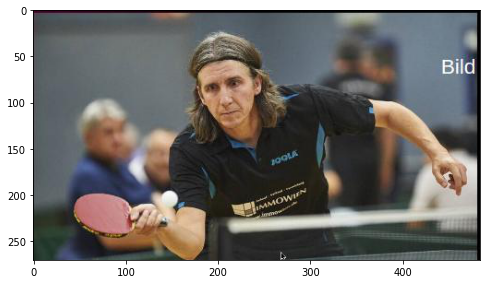


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a man in a black shirt is holding a ball with a crowd in the background <end>


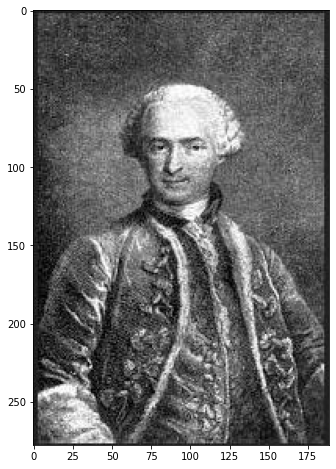


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a dirty picture of a man wearing a red and gold coat <end>


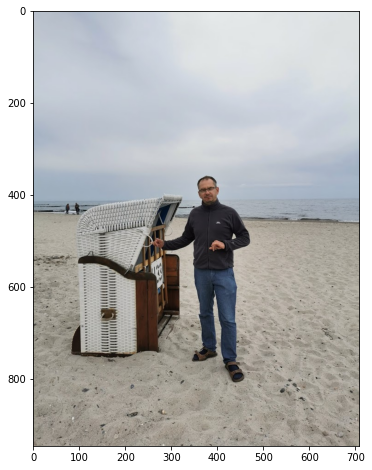


Reference captions:
--------------------------------------------------------------------------------

Prediction:
--------------------------------------------------------------------------------
- <start> a man and a boy standing on a beach <end>


In [61]:
print('Reality check with model from Version 7\n\n')

for f in os.listdir(DIR_REALITY_IMGS):
    eval_image_from_test(f, dir_images=DIR_REALITY_IMGS, dir_img_feats=DIR_REALITY_INCEPT_FEATS)